#### Задание

Основные цели этого задания:
- Попрактиковаться в борьбе с дисбалансом классов
- Научиться заполнять пропуски в данных
- Научиться использовать категориальные признаки.\
Задача: по различным признакам, связанным с заявкой на грант, предсказать, будет ли заявка принята. 

In [1]:
#pip install jinja2 missingno category_encoders
#

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE

import category_encoders as ce
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns


# pd.set_option("display.max_columns", None)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['font.size'] = 10
plt.style.use('dark_background')

  1. Загрузите данные из csv файла. Ознакомьтесь с ними, проверьте наличие пропусков, узнайте типы признаков.

In [3]:
try:
    df = pd.read_csv('grant_data_imb.csv') 
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

In [4]:
df.sample(5)

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
945,0,2B,10A,NaN,291702.0,60.0,240401.0,30.0,291804.0,10.0,...,3198.0,31.0,Yes,>=0 to 5,0.0,2.0,5.0,2.0,1.0,0.0
2,0,317A,30D,NaN,321013.0,100.0,0.0,0.0,0.0,0.0,...,2763.0,25.0,Yes,>5 to 10,4.0,3.0,6.0,25.0,14.0,14.0
370,1,29A,10B,A,321004.0,100.0,0.0,0.0,0.0,0.0,...,2713.0,25.0,NaN,Less than 0,2.0,1.0,0.0,0.0,0.0,0.0
491,1,252D,20A,K,321013.0,100.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
18,1,21A,50A,A,270105.0,40.0,321010.0,60.0,0.0,0.0,...,2763.0,25.0,Yes,>=0 to 5,1.0,1.0,0.0,1.0,3.0,0.0


In [5]:
# для удобства работы заменим названия признаков
df.columns = df.columns.str.lower()#.str.replace(".", "_")
df.columns

Index(['grant.status', 'sponsor.code', 'grant.category.code',
       'contract.value.band...see.note.a', 'rfcd.code.1', 'rfcd.percentage.1',
       'rfcd.code.2', 'rfcd.percentage.2', 'rfcd.code.3', 'rfcd.percentage.3',
       'rfcd.code.4', 'rfcd.percentage.4', 'rfcd.code.5', 'rfcd.percentage.5',
       'seo.code.1', 'seo.percentage.1', 'seo.code.2', 'seo.percentage.2',
       'seo.code.3', 'seo.percentage.3', 'seo.code.4', 'seo.percentage.4',
       'seo.code.5', 'seo.percentage.5', 'person.id.1', 'role.1',
       'year.of.birth.1', 'country.of.birth.1', 'home.language.1',
       'dept.no..1', 'faculty.no..1', 'with.phd.1',
       'no..of.years.in.uni.at.time.of.grant.1',
       'number.of.successful.grant.1', 'number.of.unsuccessful.grant.1',
       'a..1', 'a.1', 'b.1', 'c.1'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   grant.status                            4113 non-null   int64  
 1   sponsor.code                            3856 non-null   object 
 2   grant.category.code                     3856 non-null   object 
 3   contract.value.band...see.note.a        1953 non-null   object 
 4   rfcd.code.1                             3853 non-null   float64
 5   rfcd.percentage.1                       3853 non-null   float64
 6   rfcd.code.2                             3853 non-null   float64
 7   rfcd.percentage.2                       3853 non-null   float64
 8   rfcd.code.3                             3853 non-null   float64
 9   rfcd.percentage.3                       3853 non-null   float64
 10  rfcd.code.4                             3853 non-null   floa

Удалим дубликаты, если они есть.

In [7]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")
df = df.drop_duplicates().reset_index(drop=True)

Количество дубликатов: 65


In [8]:
df.shape

(4048, 39)

In [9]:
# добавим в описание данных столбец с уникальными значениями.
num_feat = df.select_dtypes(include="number")
var_ = num_feat.nunique().to_frame(name="unique")
pd.concat([var_, num_feat.describe().T], join="outer", axis=1)

,unique,count,mean,std,min,25%,50%,75%,max
grant.status,2,4048.0,0.207263,0.405396,0.0,0.0,0.0,0.0,1.0
rfcd.code.1,549,3799.0,314987.705186,47395.004340,210000.0,280401.0,320801.0,321202.0,999999.0
rfcd.percentage.1,21,3799.0,74.569097,26.855677,5.0,50.0,80.0,100.0,100.0
rfcd.code.2,526,3799.0,162425.832061,161657.262975,0.0,0.0,240204.0,320704.0,440207.0
rfcd.percentage.2,19,3799.0,17.726770,19.229527,0.0,0.0,10.0,30.0,90.0
rfcd.code.3,439,3799.0,97265.227428,149011.083605,0.0,0.0,0.0,270304.0,440207.0
rfcd.percentage.3,16,3799.0,7.131614,11.938607,0.0,0.0,0.0,20.0,70.0
rfcd.code.4,75,3799.0,6847.968939,45925.908243,0.0,0.0,0.0,0.0,440105.0
rfcd.percentage.4,11,3799.0,0.442222,3.226775,0.0,0.0,0.0,0.0,70.0
rfcd.code.5,20,3799.0,1793.120558,23764.531159,0.0,0.0,0.0,0.0,419999.0


В числовых данных много пропусков, по большей части столбцов большинство значений находится выше 50% квартиля.

In [10]:
df.describe(include='object').T

,count,unique,top,freq
sponsor.code,3803,226,4D,979
grant.category.code,3803,13,10A,2020
contract.value.band...see.note.a,1931,16,A,951
role.1,4007,7,CHIEF_INVESTIGATOR,3601
country.of.birth.1,3409,10,Australia,2501
home.language.1,389,2,English,312
with.phd.1,2304,1,Yes,2304
no..of.years.in.uni.at.time.of.grant.1,3313,5,>=0 to 5,1321


В категориальных столбцах представлено небольшое кол-во уникальных значений по каждому (кроме sponsor_code).\
Также есть столбец with_phd_1 с одним значением 'Yes'.

Итого в датасете после удаления пропусков 4048 строк и 39 столбоцов, из них 30 - float64, 1 - int64 и 8- object.

#### 2. Подготовьте данные к обучению моделей.

2.1. Отделите целевую переменную Grant.Status.

In [11]:
X = df.drop(columns='grant.status')
y = df['grant.status']

2.2 Заполните пропуски:
- в количественных признаках заполните пропуски средними значениями и нулями (у каждой фичи будет по два варианта),
- в категориальных признаках выведите значения, которые они принимают, и найдите признак, где пропуски можно заполнить осмысленным значением. В остальных признаках заполните пропуски значением по умолчанию;

<Axes: >

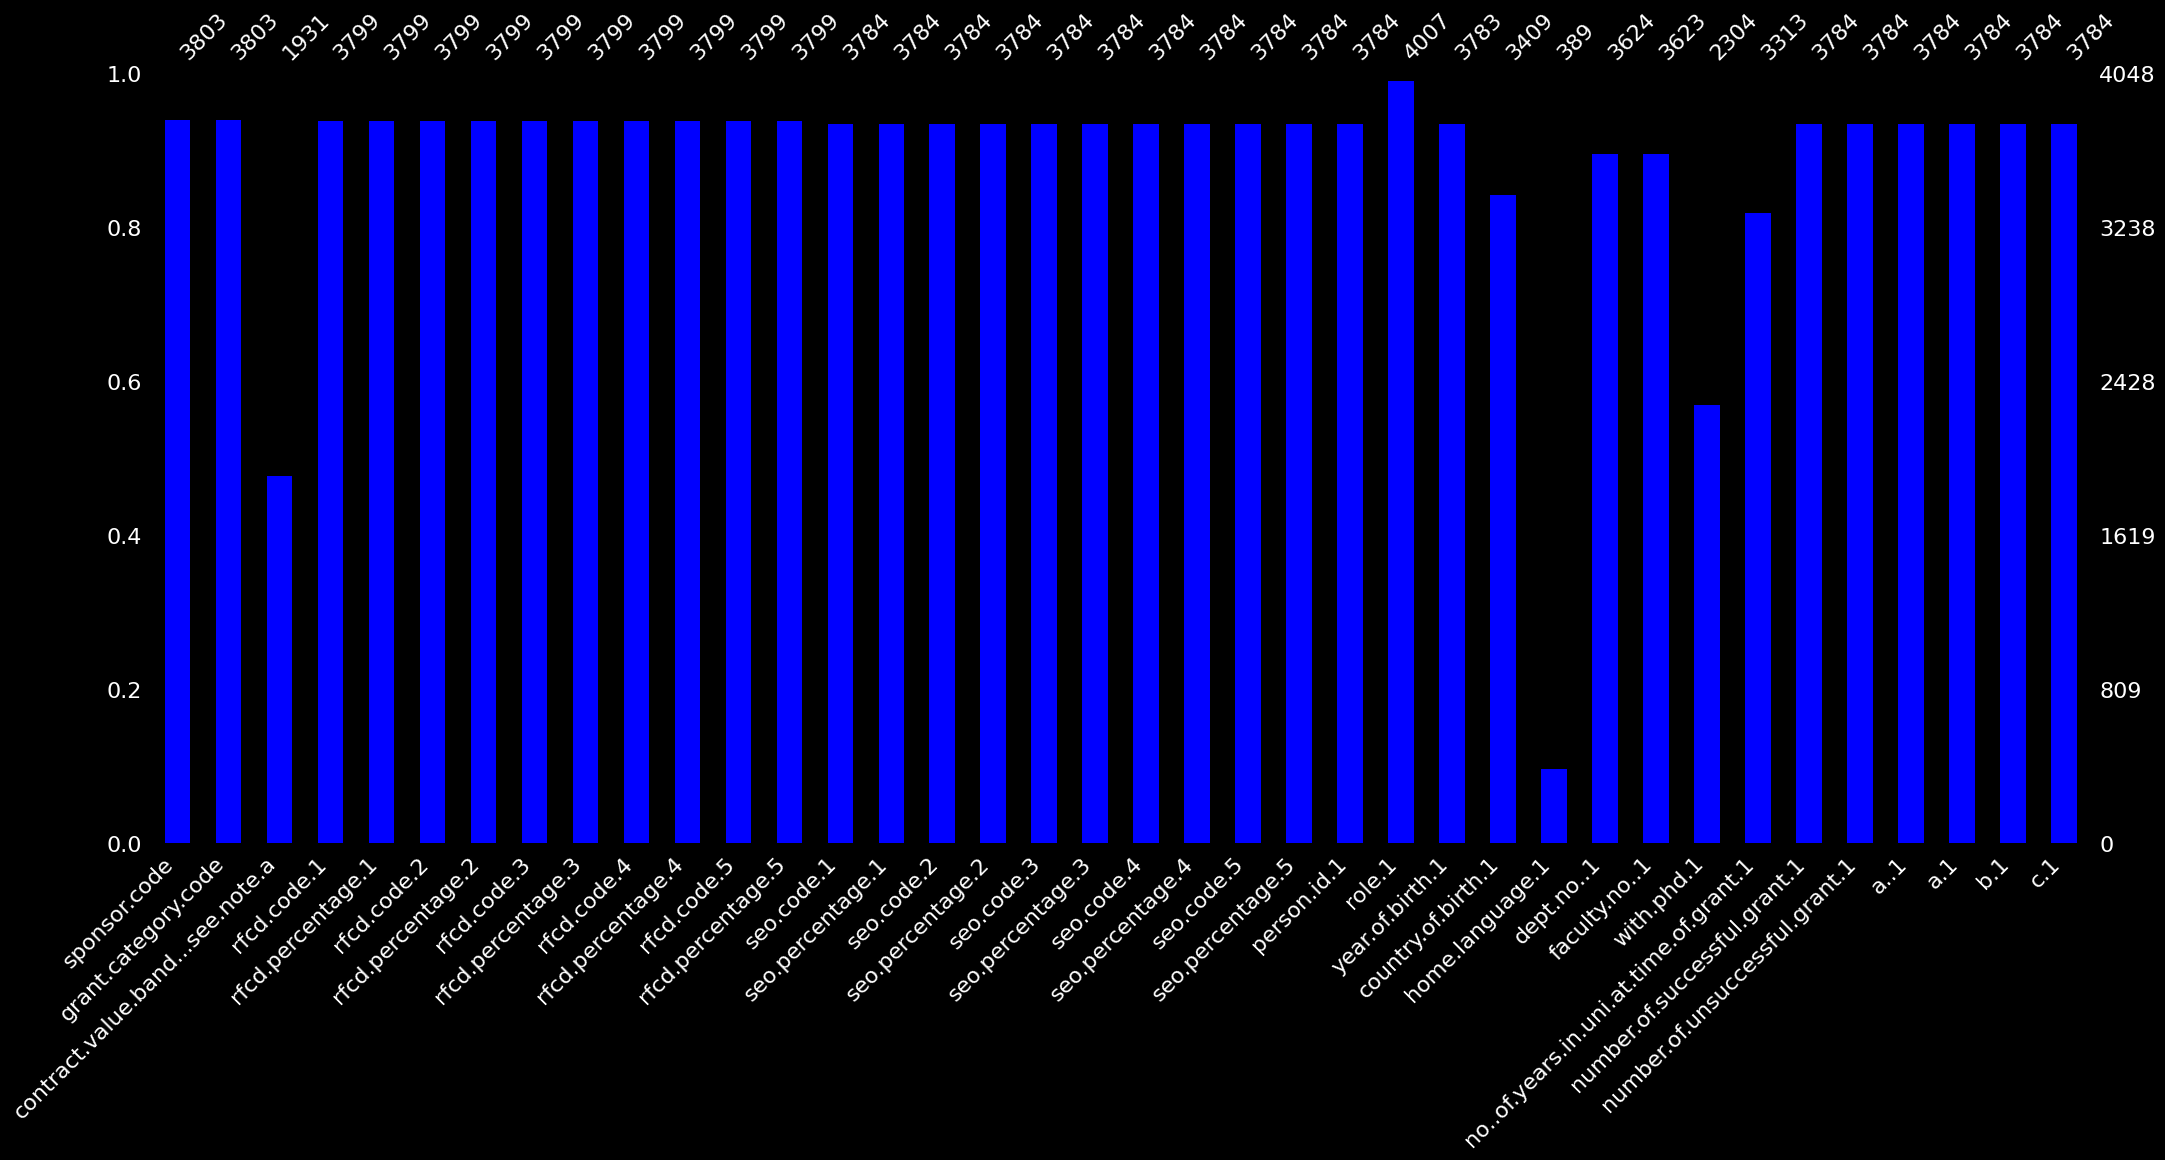

In [12]:
msno.bar(X, color='blue')

In [13]:
num_feat = X.select_dtypes(exclude="object")
cols_with_missing = [col for col in num_feat.columns if num_feat[col].isnull().any()]
print("Колонок с пропусками:", len(cols_with_missing))
# cols_with_missing

Колонок с пропусками: 30


In [14]:
num_feat_0, num_feat_mean = [], []

for col in cols_with_missing:
    X[f'{col}_0'] = X[col]
    num_feat_0.append(f'{col}_0')
    X.rename(columns={col: col +'_mean'}, inplace=True)
    num_feat_mean.append(f'{col}_mean')

In [15]:
# check
X.shape

(4048, 68)

Сделаем пайплайн для заполнения пропусков.

In [16]:
imputer_num_0 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]
)

imputer_num_mean = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

In [17]:
cat_feat = X.select_dtypes(include="object")
cat_feat.isna().sum().to_frame(name='nan')

,nan
sponsor.code,245
grant.category.code,245
contract.value.band...see.note.a,2117
role.1,41
country.of.birth.1,639
home.language.1,3659
with.phd.1,1744
no..of.years.in.uni.at.time.of.grant.1,735


Разберем каждый столбец и примем решение, как заполнять пропуски.

In [18]:
X['sponsor.code'].value_counts().to_frame()

,count
sponsor.code,
4D,979
2B,913
21A,374
24D,114
40D,89
...,...
199C,1
313A,1
373A,1


In [19]:
X['grant.category.code'].value_counts().to_frame()

,count
grant.category.code,
10A,2020
30B,699
50A,374
10B,207
20C,177
30C,145
30D,91
20A,48
30G,34


In [20]:
X.loc[(X['sponsor.code'].isna()) & (X['grant.category.code'].notna())]

,sponsor.code,grant.category.code,contract.value.band...see.note.a,rfcd.code.1_mean,rfcd.percentage.1_mean,rfcd.code.2_mean,rfcd.percentage.2_mean,rfcd.code.3_mean,rfcd.percentage.3_mean,rfcd.code.4_mean,...,person.id.1_0,year.of.birth.1_0,dept.no..1_0,faculty.no..1_0,number.of.successful.grant.1_0,number.of.unsuccessful.grant.1_0,a..1_0,a.1_0,b.1_0,c.1_0


Пропуски по этим двум столбцам одинаковые, возможно по ним нет кодов или данные поступили из другого источника.\
Заполним их по умолчанию.

In [21]:
X['contract.value.band...see.note.a'].value_counts().to_frame().T

contract.value.band...see.note.a,A,B,C,D,G,E,F,H,J,I,P,K,M,O,Q,L
count,951,302,156,147,135,97,75,32,18,11,2,1,1,1,1,1


In [22]:
(X["contract.value.band...see.note.a"].isna().sum() / X.shape[0]) * 100

np.float64(52.297430830039524)

В этом столбце много пропусков (52%), заполним по умолчанию.

In [23]:
X["role.1"].value_counts().to_frame()

,count
role.1,
CHIEF_INVESTIGATOR,3601
EXT_CHIEF_INVESTIGATOR,212
PRINCIPAL_SUPERVISOR,141
DELEGATED_RESEARCHER,36
STUD_CHIEF_INVESTIGATOR,10
HONVISIT,6
EXTERNAL_ADVISOR,1


Посмотрим столбцы country_of_birth_1 и home_language_1, по названию между ними должна быть какая-то связь.

In [24]:
X["country.of.birth.1"].value_counts(normalize=True).to_frame()

,proportion
country.of.birth.1,
Australia,0.733646
Great Britain,0.087416
Western Europe,0.045468
Asia Pacific,0.043708
North America,0.035494
Eastern Europe,0.017600
Middle East and Africa,0.011734
The Americas,0.009387
New Zealand,0.009094


Страну можно заменить на самую часто встречающуюся.

In [25]:
X["home.language.1"].value_counts().to_frame()

,count
home.language.1,
English,312
Other,77


In [26]:
(X["home.language.1"].isna().sum() / X.shape[0]) * 100

np.float64(90.3903162055336)

Мы имеем 90% пропусков в данном столбце. Можно посмотреть на его связь с country_of_birth_1.

In [27]:
X.loc[(X["country.of.birth.1"].isna()) & (X["home.language.1"].notna())]

,sponsor.code,grant.category.code,contract.value.band...see.note.a,rfcd.code.1_mean,rfcd.percentage.1_mean,rfcd.code.2_mean,rfcd.percentage.2_mean,rfcd.code.3_mean,rfcd.percentage.3_mean,rfcd.code.4_mean,...,person.id.1_0,year.of.birth.1_0,dept.no..1_0,faculty.no..1_0,number.of.successful.grant.1_0,number.of.unsuccessful.grant.1_0,a..1_0,a.1_0,b.1_0,c.1_0
711,9A,10A,NaN,291803.0,70.0,291801.0,20.0,290201.0,5.0,290501.0,...,498962.0,1970.0,2178.0,19.0,0.0,0.0,4.0,1.0,0.0,0.0
2125,210B,30B,A,350107.0,100.0,0.0,0.0,0.0,0.0,0.0,...,500252.0,1965.0,1528.0,13.0,0.0,1.0,0.0,0.0,1.0,1.0
2219,36D,10A,NaN,300406.0,100.0,0.0,0.0,0.0,0.0,0.0,...,573352.0,1965.0,1038.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3365,2B,10A,C,280112.0,50.0,280302.0,50.0,0.0,0.0,0.0,...,500202.0,1965.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X.groupby(["country.of.birth.1", "home.language.1"])["home.language.1"].agg("count")

country.of.birth.1      home.language.1
Asia Pacific            English             10
                        Other               13
Australia               English            206
                        Other                3
Eastern Europe          English              7
                        Other                8
Great Britain           English             55
Middle East and Africa  English              1
                        Other                7
North America           English             13
                        Other                1
The Americas            English              9
                        Other                8
Western Europe          English             10
                        Other               34
Name: home.language.1, dtype: int64

На основании данных можно заполнить пропуски по столбцу home_language_1 со значением Great Britain\
в столбце country_of_birth_1.\
Но по сути все пропуски по стране и языку совпадают (кроме 4 строк), можно заполнить их самым частым языком.

In [29]:
# X.loc[X['country.of.birth.1']== 'Great Britain']['home.language.1'].isna().sum()
# X.loc[X["country.of.birth.1"] == "Great Britain", "home.language.1"] = X.loc[
#     X["country.of.birth.1"] == "Great Britain", "home.language.1"
# ].fillna("English")
# (X['home.language.1'].isna().sum()/X.shape[0]) * 100

In [30]:
X['with.phd.1'].value_counts().to_frame()

,count
with.phd.1,
Yes,2304


В столбце with_phd_1 скорее всего пропуски это значения 'No',\
так как phd это ученая степень.\
Этот столбец заполним 'No'.

In [31]:
X["no..of.years.in.uni.at.time.of.grant.1"].value_counts().to_frame()

,count
no..of.years.in.uni.at.time.of.grant.1,
>=0 to 5,1321
>5 to 10,728
Less than 0,492
>10 to 15,413
more than 15,359


Тоже заполним по умолчанию.

In [32]:
imputer_cat_unknown = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown"))]
)

imputer_cat_no = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="No"))]
)

imputer_cat_country = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)


In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ("imputer_num_0", imputer_num_0, num_feat_0),
        ("imputer_num_mean", imputer_num_mean, num_feat_mean),
        ("imputer_with_phd_1", imputer_cat_no, ["with.phd.1"]),
        ("imputer_counrty", imputer_cat_country, ["country.of.birth.1", "home.language.1"]),
        (
            "imputer_categoric",
            imputer_cat_unknown,
            cat_feat.drop(columns=["with.phd.1", "country.of.birth.1", "home.language.1"], axis=1).columns,
        ),
    ]
)
preprocessor.fit(X)
X = pd.DataFrame(
    preprocessor.transform(X),
    columns=[x.split("__")[-1] for x in preprocessor.get_feature_names_out()],
)

Проверим результат:

In [34]:
cols_with_missing = [col for col in X.columns if X[col].isnull().any()]
print("Колонок с пропусками:", len(cols_with_missing))

Колонок с пропусками: 0


Уменьшим размерность числовых признаков

In [35]:
num_feat = num_feat_0 + num_feat_mean
X[num_feat] = X[num_feat].astype(np.float64)

In [36]:
for el in num_feat:
    for n_type in (np.int32, np.int16, np.int8):
        if (X[el] == X[el].astype(n_type)).sum() == len(X):
            X[el] = X[el].astype(n_type)

2.3. Преобразуйте категориальные признаки в количественные с помощью прямого кодирования.

In [37]:
# X = pd.get_dummies(X, drop_first=True, columns=cat_feat.columns)

In [38]:
encoder = ce.OneHotEncoder(cols=cat_feat.columns)
X = encoder.fit_transform(X)

In [39]:
X.shape

(4048, 346)

2.4. Разделите данные на обучающую и тестовую части.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3)

2.5. Используйте масштабирование для получения признаков одинакового масштаба.

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# check
pd.DataFrame(X_train_scaled, columns = X_train.columns).sample(3)

,rfcd.code.1_0,rfcd.percentage.1_0,rfcd.code.2_0,rfcd.percentage.2_0,rfcd.code.3_0,rfcd.percentage.3_0,rfcd.code.4_0,rfcd.percentage.4_0,rfcd.code.5_0,rfcd.percentage.5_0,...,role.1_5,role.1_6,role.1_7,role.1_8,no..of.years.in.uni.at.time.of.grant.1_1,no..of.years.in.uni.at.time.of.grant.1_2,no..of.years.in.uni.at.time.of.grant.1_3,no..of.years.in.uni.at.time.of.grant.1_4,no..of.years.in.uni.at.time.of.grant.1_5,no..of.years.in.uni.at.time.of.grant.1_6
1853,-0.292645,-0.957691,0.733222,1.219980,1.238126,1.153172,-0.144527,-0.131985,-0.072423,-0.06718,...,-0.037602,-0.098093,-0.053215,-0.018791,-0.339639,-0.366207,2.144485,-0.701872,-0.471354,-0.310423
1384,0.276102,0.947157,-0.942657,-0.869213,-0.619679,-0.567536,-0.144527,-0.131985,-0.072423,-0.06718,...,-0.037602,-0.098093,-0.053215,-0.018791,-0.339639,-0.366207,2.144485,-0.701872,-0.471354,-0.310423
1785,0.276292,0.947157,-0.942657,-0.869213,-0.619679,-0.567536,-0.144527,-0.131985,-0.072423,-0.06718,...,-0.037602,-0.098093,-0.053215,-0.018791,-0.339639,-0.366207,-0.466313,1.424762,-0.471354,-0.310423


2.6. Изучите распределение по целевой переменной, чтобы выяснить, сбалансированы ли классы.\
Если классы не сбалансированы, используйте в работе хотя бы один из изученных методов борьбы с дисбалансом классов.

In [42]:
y.isna().sum()

np.int64(0)

In [43]:
y.value_counts()

grant.status
0    3209
1     839
Name: count, dtype: int64

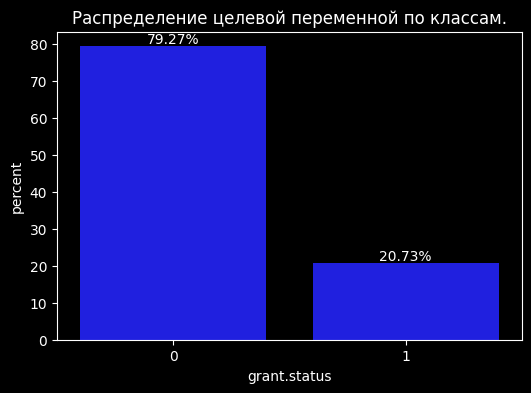

In [44]:
plt.title("Распределение целевой переменной по классам.")
ax = sns.countplot(data=y.to_frame(), x="grant.status", color="blue", stat="percent")
ax.bar_label(ax.containers[0], fmt="%.2f%%")
plt.show()

По целевой переменной наблюдается дисбаланс классов: класса 1 в 4 раза меньше, чем класса 0.

Сделаем для баланса ресемплинг и SMOTE - генерацию новых примеров. Запишем их в отдельные переменные.

In [45]:
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)
y_resampled.value_counts()

grant.status
0    2277
1    2277
Name: count, dtype: int64

In [46]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
y_smote.value_counts()

grant.status
0    2277
1    2277
Name: count, dtype: int64

#### 3. Обучите модели и выберите лучшую.

In [47]:
def visualize_roc(fpr, tpr, roc_auc, title):
    plt.title(title)
    plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.4f}")
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.axis("tight")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

In [48]:
def get_metrics_LR(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_predict_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_predict_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    print(f"Roc-auc: {roc_auc:.6f}")
    y_predict = model.predict(X_test)
    print(classification_report(y_test, y_predict))
    return roc_auc, fpr, tpr, thresholds

In [49]:
# определим параметры для моделей
cv = 10
max_iter = 100 # для ускорения работы при проверке

3.1. Обучите модель логистической регрессии, используя кросс-валидацию. Оцените ее качество с помощью метрики rocauc.

Для сравнения обучим модель с дибалансом.

In [50]:
model = LogisticRegressionCV(
    solver="liblinear", random_state=123, cv=cv, max_iter=max_iter, n_jobs=-1
)
roc_auc, fpr, tpr, thresholds = get_metrics_LR(
    model, X_train_scaled, y_train, X_test_scaled, y_test
)

Roc-auc: 0.860352
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       932
           1       0.74      0.55      0.63       283

    accuracy                           0.85      1215
   macro avg       0.80      0.75      0.77      1215
weighted avg       0.84      0.85      0.84      1215



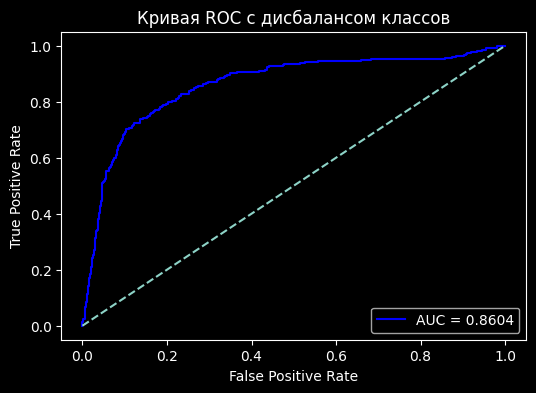

In [51]:
visualize_roc(fpr, tpr, roc_auc, "Кривая ROC с дисбалансом классов")

In [52]:
# запишем лучший результат
total_result = {}
total_result.setdefault('LogisticRegression disbalance', roc_auc)

np.float64(0.8603519919925993)

Обучим модель с гиперпараметром class_weight='balanced'.

In [53]:
model = LogisticRegressionCV(
    solver="liblinear",
    random_state=123,
    class_weight="balanced",
    cv=cv,
    max_iter=max_iter,
    n_jobs=-1
)
roc_auc, fpr, tpr, thresholds = get_metrics_LR(
    model, X_train_scaled, y_train, X_test_scaled, y_test
)

Roc-auc: 0.864420
              precision    recall  f1-score   support

           0       0.93      0.83      0.87       932
           1       0.58      0.78      0.67       283

    accuracy                           0.82      1215
   macro avg       0.75      0.81      0.77      1215
weighted avg       0.85      0.82      0.83      1215



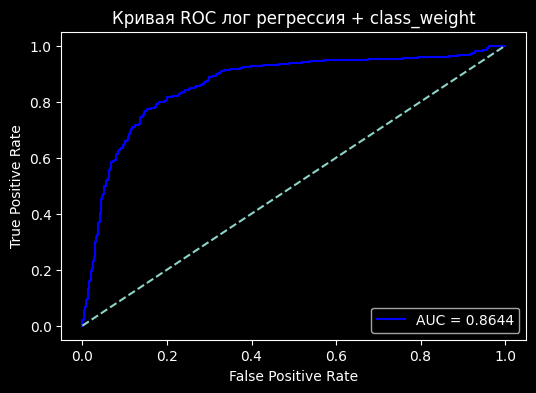

In [54]:
visualize_roc(fpr, tpr, roc_auc, "Кривая ROC лог регрессия + class_weight")

In [55]:
total_result.setdefault('LogisticRegression class_weight balanced', roc_auc)

np.float64(0.8644201458924158)

Посмотрим, что будет, если перебрать разные пороги для вероятностей.

In [56]:
# перебор порогов вероятностей
thresholds = np.arange(0.1, 1.1, 0.1)
model = LogisticRegressionCV(
    solver="liblinear", random_state=123, cv=cv, max_iter=max_iter, n_jobs=-1
)
model.fit(X_train_scaled, y_train)

res = []
for threshold in thresholds:
    # вероятности быть классом 1
    y_predict_proba = model.predict_proba(X_test_scaled)[:, -1] > threshold
    roc_auc = roc_auc_score(y_test, y_predict_proba)
    res.append([threshold, roc_auc])

    # print(f'Treshhold: {threshold:.1f}, Roc_auc: {roc_auc:.6f}')
    # print('-' * 40)
roc_auc = max(res, key=lambda x: x[1])
print(f"Treshhold: {roc_auc[0]:.1f}, Roc_auc {roc_auc[1]:.6f}")

Treshhold: 0.3, Roc_auc 0.801568


In [57]:
total_result.setdefault('LogisticRegression balanced by threshold', round(roc_auc[1], 6))

np.float64(0.801568)

<Axes: xlabel='threshold'>

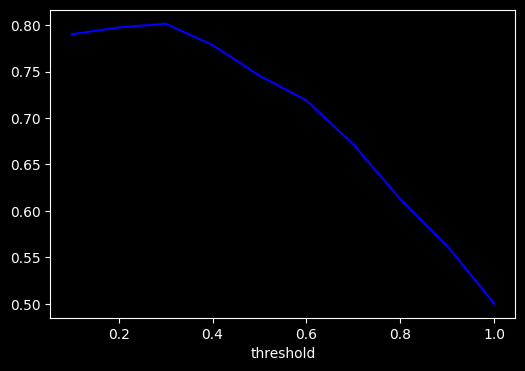

In [58]:
res_pd = pd.DataFrame(res, columns = ['threshold', 'roc_auc'])
res_pd.set_index('threshold')['roc_auc'].plot(color='blue')

Посмотрим, как будет работать модель на данных после ресемплинга и после генерации SMOTE.

In [59]:
model = LogisticRegressionCV(
    solver="liblinear", random_state=123, cv=cv, max_iter=max_iter, n_jobs=-1
)
roc_auc, fpr, tpr, thresholds = get_metrics_LR(
    model, X_resampled, y_resampled, X_test_scaled, y_test
)

Roc-auc: 0.868666
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       932
           1       0.58      0.78      0.66       283

    accuracy                           0.81      1215
   macro avg       0.75      0.80      0.77      1215
weighted avg       0.84      0.81      0.82      1215



In [60]:
model = LogisticRegressionCV(
    solver="liblinear", random_state=123, cv=cv, max_iter=max_iter, n_jobs=-1
)
roc_auc_s, fpr_s, tpr_s, thresholds_s = get_metrics_LR(
    model, X_smote, y_smote, X_test_scaled, y_test
)

Roc-auc: 0.858358
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       932
           1       0.58      0.77      0.66       283

    accuracy                           0.82      1215
   macro avg       0.75      0.80      0.77      1215
weighted avg       0.84      0.82      0.82      1215



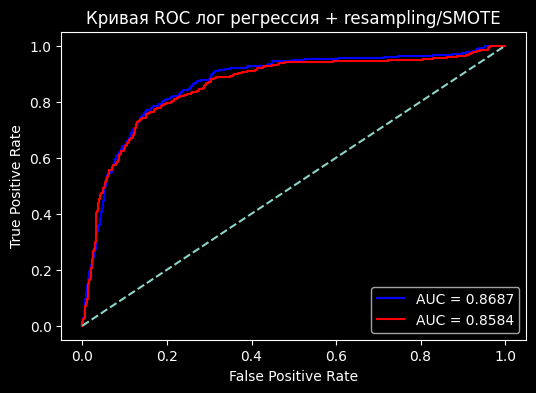

In [61]:
plt.title("Кривая ROC лог регрессия + resampling/SMOTE")
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.4f}")
plt.plot(fpr_s, tpr_s, color="red", label=f"AUC = {roc_auc_s:.4f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [62]:
total_result.setdefault('LogisticRegression balanced by resampling', round(roc_auc, 6))
total_result.setdefault('LogisticRegression balanced by SMOTE', round(roc_auc_s, 6))

np.float64(0.858358)

3.1.1. Выведите топ-10 признаков по важности, согласно обученной модели.

Для удобства возьмем последнюю обученную модель

In [63]:
pd.DataFrame(
    zip(list(X_train.columns), list(abs(model.coef_[0]))), 
    columns=['feature', 'importance']
).sort_values(by=['importance'], ascending=False).head(10).style.background_gradient()

,feature,importance
330,contract.value.band...see.note.a_16,7.235023
298,sponsor.code_225,3.769763
312,grant.category.code_12,2.786370
136,sponsor.code_63,2.786370
21,year.of.birth.1_0,2.081230
23,faculty.no..1_0,1.842684
123,sponsor.code_50,1.640715
53,faculty.no..1_mean,1.522553
22,dept.no..1_0,1.423982
166,sponsor.code_93,1.253698


3.2. Обучите модель случайного леса.

3.2.1. Для подбора гиперпараметров и кросс-валидации используйте структуру GridSearchCV.

In [64]:
model = DecisionTreeClassifier(random_state=111, class_weight='balanced')

# параметры для перебора
param_grid = dict(
    max_depth=range(1, 10),
    min_samples_leaf=range(1, 6, 2),
    min_samples_split=range(2, 8, 2), 
    criterion=['entropy', 'gini'],
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='roc_auc',
    cv=cv,
    verbose=False,
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=111),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 6, 2),
                         'min_samples_split': range(2, 8, 2)},
             scoring='roc_auc', verbose=False)

3.2.2 Выберите наилучший вариант случайного леса и выведите его параметры.

In [65]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

3.2.3. Оцените качество выбранной модели с помощью метрики rocauc.

In [66]:
grid_search.best_score_

np.float64(0.8899712110673159)

In [67]:
# получить модель с лучшими параметрами
model = grid_search.best_estimator_

y_predict_proba = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_predict_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
round(roc_auc, 4)

np.float64(0.899)

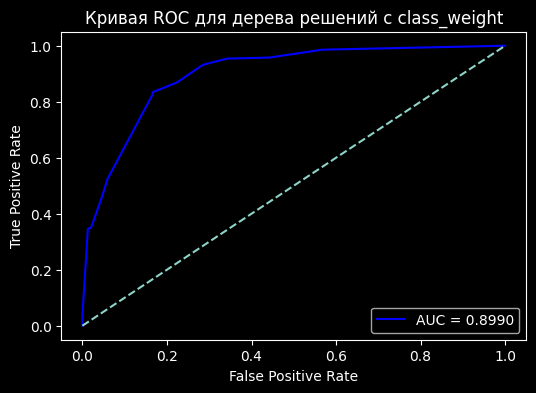

In [68]:
visualize_roc(fpr, tpr, roc_auc, "Кривая ROC для дерева решений с class_weight")

In [69]:
total_result.setdefault('DecisionTreeClassifier balanced by class_weight', round(roc_auc, 6))

np.float64(0.899017)

Попробуем дерево решений на ресемплированных данных.

In [70]:
model = DecisionTreeClassifier(random_state=123)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='roc_auc',
    cv=10,
    verbose=False,
)

grid_search.fit(X_smote, y_smote)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 6, 2),
                         'min_samples_split': range(2, 8, 2)},
             scoring='roc_auc', verbose=False)

In [71]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [72]:
grid_search.best_score_

np.float64(0.9556330489015258)

In [73]:
model = grid_search.best_estimator_

y_predict_proba = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_predict_proba)
round(roc_auc, 4)

np.float64(0.8699)

In [74]:
total_result.setdefault('DecisionTreeClassifier balanced by SMOTE', round(roc_auc, 6))

np.float64(0.869863)

3.2.4. Выведите топ-10 признаков по важности. Используйте атрибут feature_importances_, чтобы узнать важность признаков в деревянных моделях.

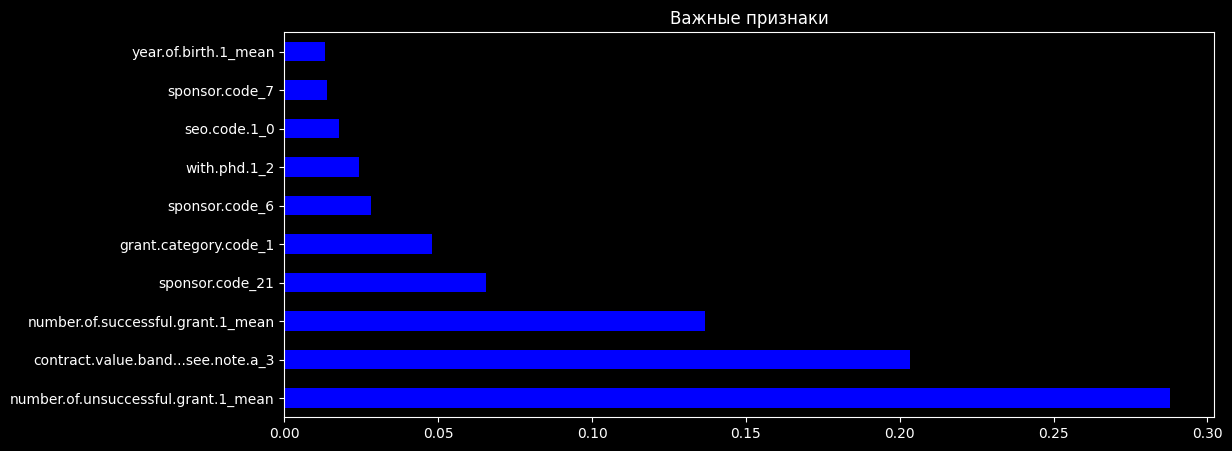

In [75]:
# Выбор важных признаков
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.title('Важные признаки')
feature_importances[:10].plot(kind='barh', figsize=(12, 5), color='blue')
plt.show()

3.3. Напишите вывод, в котором будет содержаться информация о том, какие признаки важны согласно обеим моделям, и какая модель оказалась наилучшей для решения поставленной задачи.

In [76]:
best_lr = (max(total_result, key=total_result.get))
best_lr

'DecisionTreeClassifier balanced by class_weight'

In [77]:
pd.DataFrame.from_dict(total_result, 'index', columns=['roc auc']).sort_values(by='roc auc')

,roc auc
LogisticRegression balanced by threshold,0.801568
LogisticRegression balanced by SMOTE,0.858358
LogisticRegression disbalance,0.860352
LogisticRegression class_weight balanced,0.864420
LogisticRegression balanced by resampling,0.868666
DecisionTreeClassifier balanced by SMOTE,0.869863
DecisionTreeClassifier balanced by class_weight,0.899017


*Вывод*:\
Деревянная модель показала себя однозначно лучше.
Лучшим показал себя способ балансировки через гиперпараметр class_weight,\
на втором месте генерация искусственных объектов.
Самым важным признаком по моделям дерева и логистической регрессии является - contract.value.band...see.note.a.
